# DMN and Working Memory in Human Connectome Project (HCP) Dataset

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Necessary for visualization
from nilearn import plotting, datasets

# Helper functions
from funcs import utils

# Basic parameters

In [5]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [6]:
# Configuration
DATA_FILES = [
    {"name": "hcp_rest.tgz", "url": "https://osf.io/bqp7m/download"},
    {"name": "hcp_task.tgz", "url": "https://osf.io/s4h8j/download"},
    {"name": "hcp_covariates.tgz", "url": "https://osf.io/x5p4g/download"},
    {"name": "atlas.npz", "url": "https://osf.io/j5kuc/download"}
]

HCP_DIR = Path('..') / 'data'

utils.download_and_extract_data(
    data_dir = HCP_DIR,
    files = DATA_FILES
)

2.79GiB [00:00, 5.11TiB/s]

Skipping hcp_rest.tgz: File already exists
Skipping hcp_task.tgz: File already exists
Skipping hcp_covariates.tgz: File already exists
Skipping atlas.npz: File already exists
All downloads and extractions completed!


In [7]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [8]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )
dtype = [('name', 'U16'), ('network', 'U16'), ('myelin', 'f4')]
region_array = np.array(list(zip(region_info['name'], region_info['network'], region_info['myelin'])), dtype=dtype)

ٍExtracting ROIs related to default mode network(Posterior Cingulate Cortex (PCC),
Medial Prefrontal Cortex (mPFC), Angular Gyrus (AG)) and Working Memory Network(Dorsolateral Prefrontal Cortex (DLPFC), Parietal Cortex, Supplementary Motor Area (SMA)):

In [9]:
DMN_REGIONS = region_array[region_array['network'] == 'Default']["name"]
WMN_REGIONS = region_array[region_array['network'] == "Frontopariet"]["name"]
DMN_INDEX = [region_info["name"].index(r) for r in DMN_REGIONS]
WMN_INDEX = [region_info["name"].index(r) for r in WMN_REGIONS]

In [10]:
print(DMN_REGIONS)
print(WMN_REGIONS)
print(set(region_info["network"]))
print(DMN_INDEX)
print(WMN_INDEX)

['R_55b' 'R_PSL' 'R_SFL' 'R_STV' 'R_44' 'R_45' 'R_IFJa' 'R_IFSp' 'R_STGa'
 'R_A5' 'R_STSda' 'R_STSdp' 'R_TPOJ1' 'R_TGv' 'L_55b' 'L_SFL' 'L_45'
 'L_IFJa' 'L_STGa' 'L_A5' 'L_STSdp' 'L_TPOJ1' 'L_TGv']
['R_RSC' 'R_POS2' 'R_7Pm' 'R_8BM' 'R_8C' 'R_a47r' 'R_IFJp' 'R_IFSa'
 'R_p9-46v' 'R_a9-46v' 'R_a10p' 'R_11l' 'R_13l' 'R_i6-8' 'R_s6-8' 'R_AVI'
 'R_TE1p' 'R_IP2' 'R_IP1' 'R_PFm' 'R_p10p' 'R_p47r' 'L_RSC' 'L_POS2'
 'L_7Pm' 'L_33pr' 'L_d32' 'L_8BM' 'L_8C' 'L_44' 'L_a47r' 'L_IFJp' 'L_IFSp'
 'L_p9-46v' 'L_a9-46v' 'L_a10p' 'L_11l' 'L_13l' 'L_OFC' 'L_i6-8' 'L_s6-8'
 'L_AVI' 'L_TE1p' 'L_IP2' 'L_IP1' 'L_PFm' 'L_31a' 'L_p10p' 'L_p47r'
 'L_TE1m']
{np.str_('Somatomotor'), np.str_('Cingulo-Oper'), np.str_('Ventral-Mult'), np.str_('Visual1'), np.str_('Posterior-Mu'), np.str_('Default'), np.str_('Dorsal-atten'), np.str_('Auditory'), np.str_('Visual2'), np.str_('Frontopariet'), np.str_('Orbito-Affec'), np.str_('Language')}
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [11]:
with np.load(HCP_DIR / 'atlas.npz') as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [12]:
def get_image_ids(
    name, 
    bold_names
):
    """Get the 1-based image indices for runs in a given experiment.
    
    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
      bold_names (list[str]) : List of each task acquisition
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files
    
    """
    run_ids = [
             i for i, code in enumerate(bold_names, 1) if name.upper() in code
             ]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids


def load_timeseries(
    subject,
    name,
    data_dir,
    bold_names,
    runs=None,
    concat=True,
    remove_mean=True
):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    data_dir (str) : data directory
    bold_names (list[str]) : List of each task acquisition
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name, bold_names)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      data_dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(
    subject,
    bold_run,
    data_dir,
    remove_mean=True
):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    data_dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(data_dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(
    subject, 
    name, 
    bold_names,
    condition, 
    data_dir, 
):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    bold_names (list[str]) : List of each task acquisition
    condition (str) : Name of condition
    data_dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name, bold_names):
    task_key = bold_names[id - 1]
    ev_file = os.path.join(data_dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

In [13]:
def condition_frames(run_evs, skip=0):
    """Identify timepoints corresponding to a given condition in each run.
    Args:
        run_evs (list of dicts) : Onset and duration of the event, per run
        skip (int) : Ignore this many frames at the start of each trial, to account
          for hemodynamic lag
    Returns:
        frames_list (list of 1D arrays): Flat arrays of frame indices, per run
    """
    frames_list = []
    for ev in run_evs:
        # Check if the event dictionary is empty
        if not ev:
            continue  # Skip this event and move to the next one

        # Check if 'onset' and 'duration' keys exist
        if 'onset' not in ev or 'duration' not in ev:
            continue  # Skip this event if it doesn't have required keys

        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
        frames_list.append(np.concatenate(frames))
    
    return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [14]:
test = get_image_ids('wm', BOLD_NAMES)

In [15]:
def calculate_fc(
    timeseries,
    indices
):
    timeseries = timeseries[indices, :]
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix


def plot_connectivity_matrix(matrix, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [17]:
timeseries_task = []
corr_matrices = []
frames_2back = []

for subject in subjects:
    frames_cor = []
    #### Get the LR timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR / "hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR / "hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR / "hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_lr = timeseries[:, frames_2back]

    #### Get the RL timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR / "hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR / "hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR / "hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_rl = timeseries[:, frames_2back]
    
    # Combine correct and error frames
    timeseries_2back = np.mean([timeseries_2back_lr, timeseries_2back_rl], axis=0)

    #### Compute connectivity matrix and append to list
    ####
    fc = calculate_fc(timeseries_2back, np.arange(0, 360))
    corr_matrices.append(fc)

/tmp/ipykernel_72296/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/1/EVs/tfMRI_WM_LR/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipykernel_72296/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/11/EVs/tfMRI_WM_LR/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipykernel_72296/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/11/EVs/tfMRI_WM_RL/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipykernel_72296/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/15/EVs/tfMRI_WM_LR/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipykernel_72296/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/16/EVs/tfMRI_WM_LR/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=Tr

In [23]:
def transform_fc_matrices(fc_matrix_list):
    """
    Transform a list of FC matrices into the 3D array format expected by the CPM implementation.
    
    Parameters:
    fc_matrix_list (list): List of 2D numpy arrays, each representing a subject's FC matrix.
    
    Returns:
    numpy.ndarray: 3D array with shape (n_nodes, n_nodes, n_subjects)
    """
    # Check if all matrices have the same shape
    shapes = set(matrix.shape for matrix in fc_matrix_list)
    if len(shapes) != 1:
        raise ValueError("All matrices must have the same shape")
    
    # Get the number of nodes and subjects
    n_nodes = fc_matrix_list[0].shape[0]
    n_subjects = len(fc_matrix_list)
    
    # Create the 3D array
    fc_array_3d = np.stack(fc_matrix_list, axis=2)
    
    print(f"Transformed FC matrices into 3D array with shape: {fc_array_3d.shape}")
    return fc_array_3d

In [25]:
fc_matrices = transform_fc_matrices(corr_matrices)

Transformed FC matrices into 3D array with shape: (360, 360, 339)


In [27]:
fc_matrices.shape

(360, 360, 339)

In [22]:
np.array(corr_matrices).shape

(339, 360, 360)

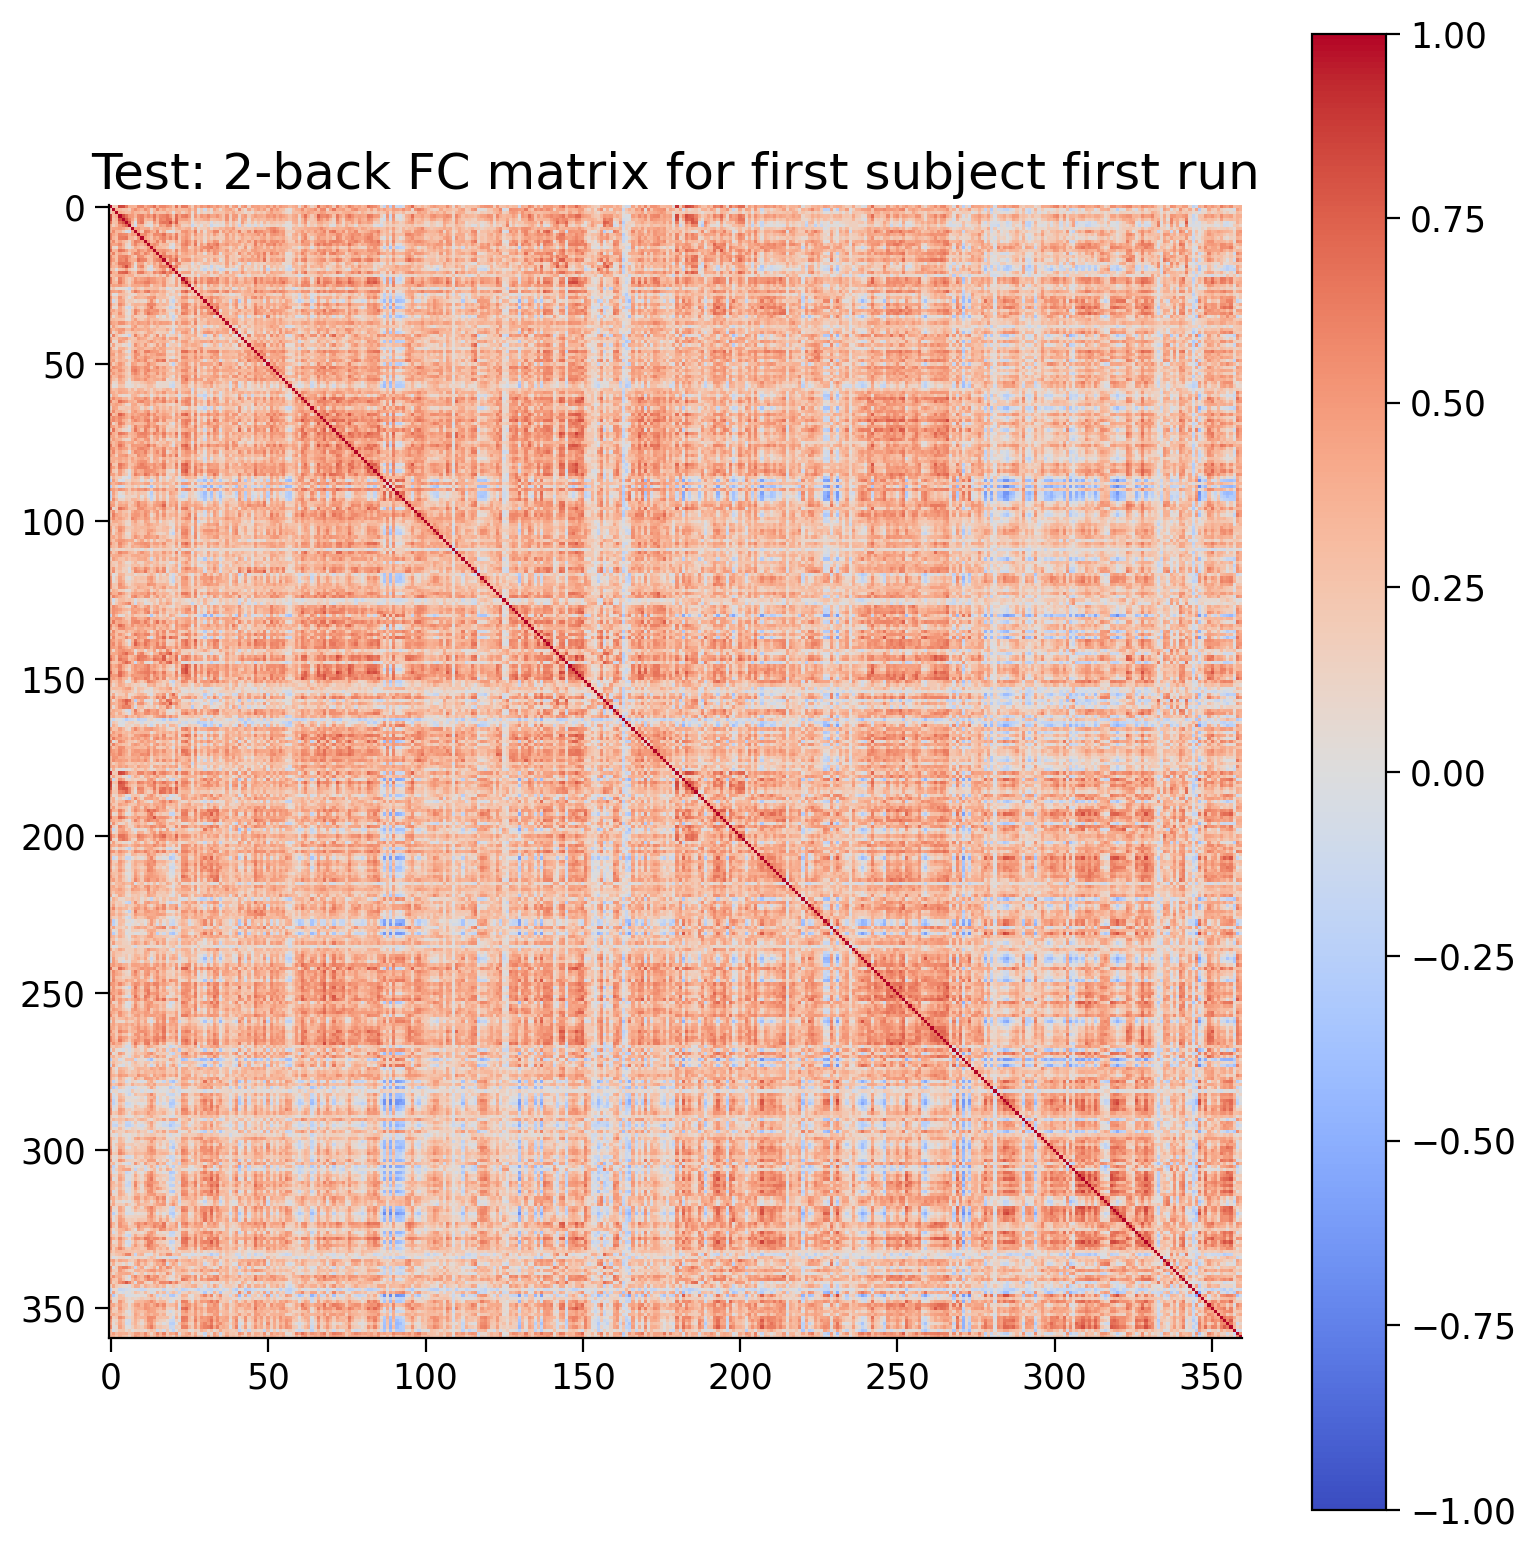

In [24]:
plot_connectivity_matrix(corr_matrices[4], 'Test: 2-back FC matrix for first subject first run')

# CPM

In [28]:
import numpy as np 
import scipy as sp
import pandas as pd
#from matplotlib import pyplot as plt
#import seaborn as sns
import glob
from scipy import stats
import random
import glob


def generate_csv_list(path):
    fn_list = glob.glob(path+'/*')
    return fn_list

def read_mats(fn_list):
    """
    Accepts list of csv file names where each csv contains a single subject FC matrix
    Returns stacked matrices
    """
    fns = [pd.read_csv(fn, header=None) for fn in fn_list]
    fns = [df.dropna(axis=1).values for df in fns]            
    fn_mats = np.stack(fns, axis=2)
    return fn_mats


def train_cpm(ipmat, pheno):

    """
    Accepts input matrices and pheno data
    Returns model
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    cpm: in cpm we select the most significant edges for subjects. so each subject
         have a pair set of edges with positive and negative correlation with behavioral subjects.
         It's important to keep both set in final regression task.  
    posedges: positive edges are a set of edges have positive
              correlatin with behavioral measures
    negedges: negative edges are a set of edges have negative
              correlation with behavioral measures
    """

    cc=[stats.pearsonr(pheno,im) for im in ipmat]
    rmat=np.array([c[0] for c in cc])
    pmat=np.array([c[1] for c in cc])
    rmat=np.reshape(rmat,[268,268])
    pmat=np.reshape(pmat,[268,268])
    posedges=(rmat > 0) & (pmat < 0.01)
    posedges=posedges.astype(int)
    negedges=(rmat < 0) & (pmat < 0.01)
    negedges=negedges.astype(int)
    pe=ipmat[posedges.flatten().astype(bool),:]
    ne=ipmat[negedges.flatten().astype(bool),:]
    pe=pe.sum(axis=0)/2
    ne=ne.sum(axis=0)/2


    if np.sum(pe) != 0:
        fit_pos=np.polyfit(pe,pheno,1)
    else:
        fit_pos=[]

    if np.sum(ne) != 0:
        fit_neg=np.polyfit(ne,pheno,1)
    else:
        fit_neg=[]

    return fit_pos,fit_neg,posedges,negedges


def kfold_cpm(X,y,k):
    """
    Accepts input matrices and pheno data
    Returns model
    Use "run_validate" instead
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    X: is the input matrix in v*n which v is number of nodes and n is the number of subjects 
    y: is the gold data which is fluid intelligence
    k: is the size of folds in k-fold
    """

    numsubs = X.shape[1]
    randinds=np.arange(0,numsubs)
    random.shuffle(randinds)

    samplesize=int(np.floor(float(numsubs)/k))

    behav_pred_pos=np.zeros([k,samplesize])
    behav_pred_neg=np.zeros([k,samplesize])

    behav_actual=np.zeros([k,samplesize])

    for fold in range(0,k):
        print("Running fold:",fold+1)
        si=fold*samplesize
        fi=(fold+1)*samplesize


        if fold != k-1:
            testinds=randinds[si:fi]
        else:
            testinds=randinds[si:]

        traininds=randinds[~np.isin(randinds,testinds)]
        
        trainmats=X[:,traininds]
        trainpheno=y[traininds]
 
        testmats=X[:,testinds]
        testpheno=y[testinds]

        behav_actual[fold,:]=testpheno


        pos_fit,neg_fit,posedges,negedges=train_cpm(trainmats,trainpheno)

        pe=np.sum(testmats[posedges.flatten().astype(bool),:], axis=0)/2
        ne=np.sum(testmats[negedges.flatten().astype(bool),:], axis=0)/2


        if len(pos_fit) > 0:
            behav_pred_pos[fold,:]=pos_fit[0]*pe + pos_fit[1]
        else:
            behav_pred_pos[fold,:]='nan'

        if len(neg_fit) > 0:
            behav_pred_neg[fold,:]=neg_fit[0]*ne + neg_fit[1]
        else:
            behav_pred_neg[fold,:]='nan'

    return behav_pred_pos,behav_pred_neg,behav_actual



def run_validate(X,y,cvtype):
    
    
    """
    Accepts input matrices (X), phenotype data (y), and the type of cross-valdiation (cv_type)    
    Returns the R-values for positive model (Rpos), negative model (Rneg), and the combination
    X: the feature matrix of size (number of nodes x number of nodes x number of subjects)
    y: the phenotype vector of size (number of subjects)
    cv_type: the cross-valdiation type, takes one of the followings: 
    1) LOO: leave-one-out cross-validation
    2) 5k: 
    """
    numsubs=X.shape[2]
    X=np.reshape(X,[-1,numsubs])

    
    if cvtype == 'LOO':
        behav_pred_pos=np.zeros([numsubs])
        behav_pred_neg=np.zeros([numsubs])
        for loo in range(0,numsubs):

            print("Running LOO, sub no:",loo)
      
            train_mats=np.delete(X,[loo],axis=1)
            train_pheno=np.delete(pheno,[loo],axis=0)
            
            test_mat=X[:,loo]
            test_pheno=y[loo]

            pos_fit,neg_fit,posedges,negedges=train_cpm(train_mats,train_pheno)

            pe=np.sum(test_mat[posedges.flatten().astype(bool)])/2
            ne=np.sum(test_mat[negedges.flatten().astype(bool)])/2

            if len(pos_fit) > 0:
                behav_pred_pos[loo]=pos_fit[0]*pe + pos_fit[1]
            else:
                behav_pred_pos[loo]='nan'

            if len(neg_fit) > 0:
               behav_pred_neg[loo]=neg_fit[0]*ne + neg_fit[1]
            else:
                behav_pred_neg[loo]='nan'

        
        Rpos=stats.pearsonr(behav_pred_pos,pheno)[0]
        Rneg=stats.pearsonr(behav_pred_neg,pheno)[0]

        return Rpos,Rneg


    elif cvtype == '5k':
        bp,bn,ba=kfold_cpm(X,y,5)



        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,5)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,5)])
        Rneg_mean=ccn.mean(axis=0)[0]



    elif cvtype == '10k':
        bp,bn,ba=kfold_cpm(X,y,10)


        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,10)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,10)])
        Rneg_mean=ccn.mean(axis=0)[0]



    elif cvtype == 'splithalf':
        bp,bn,ba=kfold_cpm(X,y,2)

        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,2)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,2)])
        Rneg_mean=ccn.mean(axis=0)[0]


    else:
        raise Exception('cvtype must be LOO, 5k, 10k, or splithalf')


    return Rpos_mean,Rneg_mean
    


def sample_500(X,y,cv_type):
    """
    Accepts input matrices and pheno data
    Returns 500 random samples from data
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    X: is the input matrix in v*v*n which v is number of nodes and n is the number of subjects 
    y: is the gold data which is fluid intelligence
    k: is the size of folds in k-fold
    """


    numsubs=ipmats.shape[2]

    randinds=np.arange(0,numsubs)
    random.shuffle(randinds)

    randinds500=randinds[:500]

    ipmats_rand=ipmats[:,:,randinds500]
    pheno_rand=pheno[randinds500]

    opdict={}

    Rpos_loo,Rneg_loo=run_validate(ipmats_rand,pheno_rand,'LOO')
    
    Rpos_2k,Rneg_2k=run_validate(ipmats_rand,pheno_rand,'splithalf')

    Rpos_5k,Rneg_5k=run_validate(ipmats_rand,pheno_rand,'5k')

    Rpos_10k,Rneg_10k=run_validate(ipmats_rand,pheno_rand,'10k')

    opdict['LOO_Rpos'] = Rpos_loo
    opdict['LOO_Rneg'] = Rneg_loo
    opdict['2k_Rpos'] = Rpos_2k
    opdict['2k_Rneg'] = Rneg_2k
    opdict['5k_Rpos'] = Rpos_5k
    opdict['5k_Rneg'] = Rneg_5k
    opdict['10k_Rpos'] = Rpos_10k
    opdict['10k_Rneg'] = Rneg_10k
    opdict['Sample_Indices']=randinds500

    return opdict